# Assignment: Policy Evaluation in Cliff Walking Environment

Welcome to the Course 2 Module 2 Programming Assignment! In this assignment, you will implement one of the fundamental sample and bootstrapping based model free reinforcement learning agents for prediction. This is namely one that uses one-step temporal difference learning, also known as TD(0). The task is to design an agent for policy evaluation in the Cliff Walking environment. Recall that policy evaluation is the prediction problem where the goal is to accurately estimate the values of states given some policy.

### Learning Objectives
- Implement parts of the Cliff Walking environment, to get experience specifying MDPs [Section 1].
- Implement an agent that uses bootstrapping and, particularly, TD(0) [Section 2].
- Apply TD(0) to estimate value functions for different policies, i.e., run policy evaluation experiments [Section 3].

## The Cliff Walking Environment

The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.

The diagram below showcases the description above and also illustrates two of the policies we will be evaluating.

<img src="cliffwalk.png" style="height:400px">

## Packages.

We import the following libraries that are required for this assignment. We shall be using the following libraries:
1. jdc: Jupyter magic that allows defining classes over multiple jupyter notebook cells.
2. numpy: the fundamental package for scientific computing with Python.
3. matplotlib: the library for plotting graphs in Python.
4. RL-Glue: the library for reinforcement learning experiments.
5. BaseEnvironment, BaseAgent: the base classes from which we will inherit when creating the environment and agent classes in order for them to support the RL-Glue framework.
6. Manager: the file allowing for visualization and testing.
7. itertools.product: the function that can be used easily to compute permutations.
8. tqdm.tqdm: Provides progress bars for visualizing the status of loops.

**Please do not import other libraries** this will break the autograder.

**NOTE: For this notebook, there is no need to make any calls to methods of random number generators. Spurious or missing calls to random number generators may affect your results.**

In [83]:
# Do not modify this cell!

import jdc
import numpy as np
from rl_glue import RLGlue
from Agent import BaseAgent 
from Environment import BaseEnvironment  
from manager import Manager
from itertools import product
from tqdm import tqdm

## Section 1. Environment

In the first part of this assignment, you will get to see how the Cliff Walking environment is implemented. You will also get to implement parts of it to aid your understanding of the environment and more generally how MDPs are specified. In particular, you will implement the logic for:
 1. Converting 2-dimensional coordinates to a single index for the state,
 2. One of the actions (action up), and,
 3. Reward and termination.
 
Given below is an annotated diagram of the environment with more details that may help in completing the tasks of this part of the assignment. Note that we will be creating a more general environment where the height and width positions can be variable but the start, goal and cliff grid cells have the same relative positions (bottom left, bottom right and the cells between the start and goal grid cells respectively).

<img src="cliffwalk-annotated.png" style="height:400px">

Once you have gone through the code and begun implementing solutions, it may be a good idea to come back here and see if you can convince yourself that the diagram above is an accurate representation of the code given and the code you have written.

In [84]:
# ---------------
# Discussion Cell
# ---------------

# Create empty CliffWalkEnvironment class.
# These methods will be filled in later cells.
class CliffWalkEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        raise NotImplementedError

    def env_start(self):
        raise NotImplementedError

    def env_step(self, action):
        raise NotImplementedError

    def env_cleanup(self):
        raise NotImplementedError
    
    # helper method
    def state(self, loc):
        raise NotImplementedError

## env_init()

The first function we add to the environment is the initialization function which is called once when an environment object is created. In this function, the grid dimensions and special locations (start and goal locations and the cliff locations) are stored for easy use later.

In [85]:
%%add_to CliffWalkEnvironment

# ---------------
# Discussion Cell
# ---------------

def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.
        Note:
            Initialize a tuple with the reward, first state, boolean
            indicating if it's terminal.
        """
        
        # Note, we can setup the following variables later, in env_start() as it is equivalent. 
        # Code is left here to adhere to the note above, but these variables are initialized once more
        # in env_start() [See the env_start() function below.]
        
        reward = None
        state = None # See Aside
        termination = None
        self.reward_state_term = (reward, state, termination)
        
        # AN ASIDE: Observation is a general term used in the RL-Glue files that can be interachangeably 
        # used with the term "state" for our purposes and for this assignment in particular. 
        # A difference arises in the use of the terms when we have what is called Partial Observability where 
        # the environment may return states that may not fully represent all the information needed to 
        # predict values or make decisions (i.e., the environment is non-Markovian.)
        
        # Set the default height to 4 and width to 12 (as in the diagram given above)
        self.grid_h = env_info.get("grid_height", 4) 
        self.grid_w = env_info.get("grid_width", 12)
        
        # Now, we can define a frame of reference. Let positive x be towards the direction down and 
        # positive y be towards the direction right (following the row-major NumPy convention.)
        # Then, keeping with the usual convention that arrays are 0-indexed, max x is then grid_h - 1 
        # and max y is then grid_w - 1. So, we have:
        # Starting location of agent is the bottom-left corner, (max x, min y). 
        self.start_loc = (self.grid_h - 1, 0)
        # Goal location is the bottom-right corner. (max x, max y).
        self.goal_loc = (self.grid_h - 1, self.grid_w - 1)
        
        # The cliff will contain all the cells between the start_loc and goal_loc.
        self.cliff = [(self.grid_h - 1, i) for i in range(1, (self.grid_w - 1))]
        
        # Take a look at the annotated environment diagram given in the above Jupyter Notebook cell to 
        # verify that your understanding of the above code is correct for the default case, i.e., where 
        # height = 4 and width = 12.

## *Implement* state()
    
The agent location can be described as a two-tuple or coordinate (x, y) describing the agentâ€™s position. 
However, we can convert the (x, y) tuple into a single index and provide agents with just this integer.
One reason for this choice is that the spatial aspect of the problem is secondary and there is no need 
for the agent to know about the exact dimensions of the environment. 
From the agentâ€™s viewpoint, it is just perceiving some states, accessing their corresponding values 
in a table, and updating them. Both the coordinate (x, y) state representation and the converted coordinate representation are thus equivalent in this sense.

Given a grid cell location, the state() function should return the state; a single index corresponding to the location in the grid.


```
Example: Suppose grid_h is 2 and grid_w is 2. Then, we can write the grid cell two-tuple or coordinate
states as follows (following the usual 0-index convention):
|(0, 0) (0, 1)| |0 1|
|(1, 0) (1, 1)| |2 3|
Assuming row-major order as NumPy does,  we can flatten the latter to get a vector [0 1 2 3].
So, if loc = (0, 0) we return 0. While, for loc = (1, 1) we return 3.
```

In [86]:
%%add_to CliffWalkEnvironment

# -----------
# Graded Cell
# -----------

# Modify the return statement of this function to return a correct single index as 
# the state (see the logic for this in the previous cell.)
def state(self, loc):
    i, j = loc
    return i * self.grid_w + j    

In [87]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

env = CliffWalkEnvironment()
env.env_init({ "grid_height": 4, "grid_width": 12 })

coords = [(0, 0), (0, 11), (1, 5), (3, 0), (3, 9), (3, 11)]
correct_outputs = [0, 11, 17, 36, 45, 47]

got = [env.state(s) for s in coords]
assert got == correct_outputs

In [88]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

env = CliffWalkEnvironment()
for n in range(100):
    # make a gridworld of random size and shape
    height = np.random.randint(2, 100)
    width = np.random.randint(2, 100)
    env.env_init({ "grid_height": height, "grid_width": width })
    
    # generate some random coordinates within the grid
    idx_h = np.random.randint(height)
    idx_w = np.random.randint(width)
    
    # check that the state index is correct
    state = env.state((idx_h, idx_w))
    correct_state = width * idx_h + idx_w
    
    assert state == correct_state

## env_start()

In env_start(), we initialize the agent location to be the start location and return the state corresponding to it as the first state for the agent to act upon. Additionally, we also set the reward and termination terms to be 0 and False respectively as they are consistent with the notion that there is no reward nor termination before the first action is even taken.

In [89]:
%%add_to CliffWalkEnvironment

# ---------------
# Discussion Cell
# ---------------

def env_start(self):
    """The first method called when the episode starts, called before the
    agent starts.

    Returns:
        The first state from the environment.
    """
    reward = 0
    # agent_loc will hold the current location of the agent
    self.agent_loc = self.start_loc
    # state is the one dimensional state representation of the agent location.
    state = self.state(self.agent_loc)
    termination = False
    self.reward_state_term = (reward, state, termination)

    return self.reward_state_term[1]

## *Implement* env_step()

Once an action is taken by the agent, the environment must provide a new state, reward and termination signal. 

In the Cliff Walking environment, agents move around using a 4-cell neighborhood called the Von Neumann neighborhood (https://en.wikipedia.org/wiki/Von_Neumann_neighborhood). Thus, the agent has 4 available actions at each state. Three of the actions have been implemented for you and your first task is to implement the logic for the fourth action (Action UP).

Your second task for this function is to implement the reward logic. Look over the environment description given earlier in this notebook if you need a refresher for how the reward signal is defined.

In [90]:
%%add_to CliffWalkEnvironment

# -----------
# Graded Cell
# -----------
    

# Fill in the code for action UP and implement the logic for reward and termination.
def env_step(self, action):
    """A step taken by the environment.

    Args:
        action: The action taken by the agent

    Returns:
        (float, state, Boolean): a tuple of the reward, state,
            and boolean indicating if it's terminal.
    """
    
    x, y = self.agent_loc

    # UP
    if action == 0:
        # Hint: Look at the code given for the other actions and think about the logic in them.
        
        # If the square is within bounds, move up, else stay where you are.
        candidate_loc = (self.agent_loc[0] - 1, self.agent_loc[1])
        if candidate_loc[0] >= 0:
            self.agent_loc = candidate_loc
        else:
            pass
        
    # LEFT
    elif action == 1:
        candidate_loc = (self.agent_loc[0], self.agent_loc[1] - 1)
        if candidate_loc[0] >= 0:
            self.agent_loc = candidate_loc
        else:
            pass
        
    # DOWN
    elif action == 2:
        candidate_loc = (self.agent_loc[0] + 1, self.agent_loc[1])
        if candidate_loc[0] < self.grid_h:
            self.agent_loc = candidate_loc
        else:
            pass
        
    # RIGHT
    elif action == 3:
        candidate_loc = (self.agent_loc[0], self.agent_loc[1] + 1)
        if candidate_loc[0] < self.grid_h:
            self.agent_loc = candidate_loc
        else:
            pass
        
    # Uh-oh
    else: 
        raise Exception(str(action) + " not in recognized actions [0: Up, 1: Left, 2: Down, 3: Right]!")

    # by default, assume -1 reward per step and that we did not terminate
    reward = -1
    terminal = False
    
    # assign the reward and terminal variables 
    # - if the agent falls off the cliff (don't forget to reset agent location!)
    # - if the agent reaches the goal state
    
    # If the agent reaches the goal
    if self.agent_loc == self.goal_loc:
        reward = -1
        terminal = True
    # If the agent fell off the cliff
    elif self.agent_loc in self.cliff:
        reward = -100
        terminal = False
        self.agent_loc = self.start_loc
    else: 
        reward = -1
        terminal = False
    
    self.reward_state_term = (reward, self.state(self.agent_loc), terminal)
    return self.reward_state_term

In [91]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

def test_action_up():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})
    env.agent_loc = (0, 0)
    env.env_step(0)
    assert(env.agent_loc == (0, 0))
    
    env.agent_loc = (1, 0)
    env.env_step(0)
    assert(env.agent_loc == (0, 0))
    
def test_reward():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})
    env.agent_loc = (0, 0)
    reward_state_term = env.env_step(0)
    assert(reward_state_term[0] == -1 and reward_state_term[1] == env.state((0, 0)) and
           reward_state_term[2] == False)
    
    env.agent_loc = (3, 1)
    reward_state_term = env.env_step(2)
    assert(reward_state_term[0] == -100 and reward_state_term[1] == env.state((3, 0)) and
           reward_state_term[2] == False)
    
    env.agent_loc = (2, 11)
    reward_state_term = env.env_step(2)
    assert(reward_state_term[0] == -1 and reward_state_term[1] == env.state((3, 11)) and
           reward_state_term[2] == True)
    
test_action_up()
test_reward()

In [92]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
np.random.seed(0)

env = CliffWalkEnvironment()
for n in range(100):
    # create a cliff world of random size
    height = np.random.randint(2, 100)
    width = np.random.randint(2, 100)
    env.env_init({"grid_height": height, "grid_width": width})
    
    # start the agent in a random location
    idx_h = 0 if np.random.random() < 0.5 else np.random.randint(height)
    idx_w = np.random.randint(width)
    env.agent_loc = (idx_h, idx_w)
    
    env.env_step(0)
    assert(env.agent_loc == (0 if idx_h == 0 else idx_h - 1, idx_w))

In [93]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.
np.random.seed(0)

env = CliffWalkEnvironment()
for n in range(100):
    # create a cliff world of random size
    height = np.random.randint(4, 10)
    width = np.random.randint(4, 10)
    env.env_init({"grid_height": height, "grid_width": width})
    env.env_start()
    
    # start the agent near the cliff
    idx_h = height - 2
    idx_w = np.random.randint(1, width - 2)
    env.agent_loc = (idx_h, idx_w)
    
    r, sp, term = env.env_step(2)
    assert(r == -100 and sp == (height - 1) * width and term == False)

for n in range(100):
    # create a cliff world of random size
    height = np.random.randint(4, 10)
    width = np.random.randint(4, 10)
    env.env_init({"grid_height": height, "grid_width": width})
    env.env_start()
    
    # start the agent near the goal
    idx_h = height - 2
    idx_w = width - 1
    env.agent_loc = (idx_h, idx_w)
    
    r, sp, term = env.env_step(2)
    assert(r == -1 and sp == (height - 1) * width + (width - 1) and term == True)

for n in range(100):
    # create a cliff world of random size
    height = np.random.randint(4, 10)
    width = np.random.randint(4, 10)
    env.env_init({"grid_height": height, "grid_width": width})
    env.env_start()
    
    # start the agent in a random location
    idx_h = np.random.randint(0, height - 3)
    idx_w = np.random.randint(0, width - 1)
    env.agent_loc = (idx_h, idx_w)
    
    r, sp, term = env.env_step(2)
    assert(r == -1 and term == False)

## env_cleanup()

There is not much cleanup to do for the Cliff Walking environment. Here, we simply reset the agent location to be the start location in this function.

In [94]:
%%add_to CliffWalkEnvironment

# ---------------
# Discussion Cell
# ---------------

def env_cleanup(self):
    """Cleanup done after the environment ends"""
    self.agent_loc = self.start_loc

## Section 2. Agent

In this second part of the assignment, you will be implementing the key updates for Temporal Difference Learning. There are two cases to consider depending on whether an action leads to a terminal state or not.

In [95]:
# ---------------
# Discussion Cell
# ---------------

# Create empty TDAgent class.
# These methods will be filled in later cells.

class TDAgent(BaseAgent):
    def agent_init(self, agent_info={}):
        raise NotImplementedError
        
    def agent_start(self, state):
        raise NotImplementedError

    def agent_step(self, reward, state):
        raise NotImplementedError

    def agent_end(self, reward):
        raise NotImplementedError

    def agent_cleanup(self):        
        raise NotImplementedError
        
    def agent_message(self, message):
        raise NotImplementedError

## agent_init()

As we did with the environment, we first initialize the agent once when a TDAgent object is created. In this function, we create a random number generator, seeded with the seed provided in the agent_info dictionary to get reproducible results. We also set the policy, discount and step size based on the agent_info dictionary. Finally, with a convention that the policy is always specified as a mapping from states to actions and so is an array of size (# States, # Actions), we initialize a values array of shape (# States,) to zeros.

In [96]:
%%add_to TDAgent

# ---------------
# Discussion Cell
# ---------------

def agent_init(self, agent_info={}):
    """Setup for the agent called when the experiment first starts."""

    # Create a random number generator with the provided seed to seed the agent for reproducibility.
    self.rand_generator = np.random.RandomState(agent_info.get("seed"))

    # Policy will be given, recall that the goal is to accurately estimate its corresponding value function. 
    self.policy = agent_info.get("policy")
    # Discount factor (gamma) to use in the updates.
    self.discount = agent_info.get("discount")
    # The learning rate or step size parameter (alpha) to use in updates.
    self.step_size = agent_info.get("step_size")

    # Initialize an array of zeros that will hold the values.
    # Recall that the policy can be represented as a (# States, # Actions) array. With the 
    # assumption that this is the case, we can use the first dimension of the policy to
    # initialize the array for values.
    self.values = np.zeros((self.policy.shape[0],))

# agent_start()

In agent_start(), we choose an action based on the initial state and policy we are evaluating. We also cache the state so that we can later update its value when we perform a Temporal Difference update. Finally, we return the action chosen so that the RL loop can continue and the environment can execute this action.

In [97]:
%%add_to TDAgent

# ---------------
# Discussion Cell
# ---------------

def agent_start(self, state):
    """The first method called when the episode starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the environment's env_start function.
    Returns:
        The first action the agent takes.
    """
    # The policy can be represented as a (# States, # Actions) array. So, we can use 
    # the second dimension here when choosing an action.
    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state
    return action

## *Implement* agent_step()

In agent_step(), the agent must:

- Perform an update to improve the value estimate of the previously visited state, and
- Act based on the state provided by the environment.

The latter of the two steps above has been implemented for you. Implement the former. Note that, unlike later in agent_end(), the episode has not yet ended in agent_step(). in other words, the previously observed state was not a terminal state.

In [98]:
%%add_to TDAgent

# -----------
# Graded Cell
# -----------

def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step after the last action, i.e., where the agent ended up after the
            last action
    Returns:
        The action the agent is taking.
    """
    
    # Hint: We should perform an update with the last state given that we now have the reward and
    # next state. We break this into two steps. Recall for example that the Monte-Carlo update 
    # had the form: V[S_t] = V[S_t] + alpha * (target - V[S_t]), where the target was the return, G_t.
    
    target = reward + self.discount * self.values[state]
    self.values[self.last_state] = self.values[self.last_state] + self.step_size * (target - self.values[self.last_state])
    

    # Having updated the value for the last state, we now act based on the current 
    # state, and set the last state to be current one as we will next be making an 
    # update with it when agent_step is called next once the action we return from this function 
    # is executed in the environment.

    action = self.rand_generator.choice(range(self.policy.shape[1]), p=self.policy[state])
    self.last_state = state

    return action

## *Implement* agent_end() 

Implement the TD update for the case where an action leads to a terminal state.

In [99]:
%%add_to TDAgent

# -----------
# Graded Cell
# -----------

def agent_end(self, reward):
    """Run when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the terminal state.
    """
    
    # Hint: Here too, we should perform an update with the last state given that we now have the 
    # reward. Note that in this case, the action led to termination. Once more, we break this into 
    # two steps, computing the target and the update itself that uses the target and the 
    # current value estimate for the state whose value we are updating.
    
    target = reward
    self.values[self.last_state]= self.values[self.last_state] + self.step_size * (target - self.values[self.last_state])
    

## agent_cleanup()

In cleanup, we simply reset the last state to be None to ensure that we are not storing any states past an episode.

In [100]:
%%add_to TDAgent

# ---------------
# Discussion Cell
# ---------------

def agent_cleanup(self):
    """Cleanup done after the agent ends."""
    self.last_state = None

## agent_message()

agent_message() can generally be used to get different kinds of information about an RLGlue agent in the interaction loop of RLGlue. Here, we conditonally check for a message matching "get_values" and use it to retrieve the values table the agent has been updating over time.

In [101]:
%%add_to TDAgent

# ---------------
# Discussion Cell
# ---------------

def agent_message(self, message):
    """A function used to pass information from the agent to the experiment.
    Args:
        message: The message passed to the agent.
    Returns:
        The response (or answer) to the message.
    """
    if message == "get_values":
        return self.values
    else:
        raise Exception("TDAgent.agent_message(): Message not understood!")

In [102]:
# --------------
# Debugging Cell
# --------------
# Feel free to make any changes to this cell to debug your code

# The following test checks that the TD check works for a case where the transition 
# garners reward -1 and does not lead to a terminal state. This is in a simple two state setting 
# where there is only one action. The first state's current value estimate is 0 while the second is 1.
# Note the discount and step size if you are debugging this test.
agent = TDAgent()
policy_list = np.array([[1.], [1.]])
agent.agent_init({"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1})
agent.values = np.array([0., 1.])
agent.agent_start(0)

reward = -1
next_state = 1
agent.agent_step(reward, next_state)

assert(np.isclose(agent.values[0], -0.001) and np.isclose(agent.values[1], 1.))

# The following test checks that the TD check works for a case where the transition 
# garners reward -100 and lead to a terminal state. This is in a simple one state setting 
# where there is only one action. The state's current value estimate is 0.
# Note the discount and step size if you are debugging this test.
agent = TDAgent()
policy_list = np.array([[1.]])
agent.agent_init({"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1})
agent.values = np.array([0.])
agent.agent_start(0)

reward = -100
next_state = 0
agent.agent_end(reward)

assert(np.isclose(agent.values[0], -10))

In [103]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent = TDAgent()
policy_list = [np.random.dirichlet(np.ones(10), size=1).squeeze() for _ in range(100)]

for n in range(100):
    gamma = np.random.random()
    alpha = np.random.random()
    agent.agent_init({"policy": np.array(policy_list), "discount": gamma, "step_size": alpha})
    agent.values = np.random.randn(*agent.values.shape)
    state = np.random.randint(100)
    agent.agent_start(state)
    
    for _ in range(100):
        prev_agent_vals = agent.values.copy()
        reward = np.random.random()
        if np.random.random() > 0.1:
            next_state = np.random.randint(100)
            agent.agent_step(reward, next_state)
            prev_agent_vals[state] = prev_agent_vals[state] + alpha * (reward + gamma * prev_agent_vals[next_state] - prev_agent_vals[state])
            assert(np.allclose(prev_agent_vals, agent.values))
            state = next_state
        else:
            agent.agent_end(reward)
            prev_agent_vals[state] = prev_agent_vals[state] + alpha * (reward - prev_agent_vals[state])
            assert(np.allclose(prev_agent_vals, agent.values))
            break

## Section 3. Policy Evaluation Experiments

Finally, in this last part of the assignment, you will get to see the TD policy evaluation algorithm in action by looking at the estimated values, the per state value error and after the experiment is complete, the Mean Squared Value Error curve vs. episode number, summarizing how the value error changed over time.

The code below runs one run of an experiment given env_info and agent_info dictionaries. A "manager" object is created for visualizations and is used in part for the autograder. By default, the run will be for 5000 episodes. The true_values_file is specified to compare the learned value function with the values stored in the true_values_file. Plotting of the learned value  function occurs by default after every 100 episodes. In addition, when true_values_file is specified, the value error per state and the root mean square value error will also be plotted.

In [104]:
%matplotlib notebook

# ---------------
# Discussion Cell
# ---------------

def run_experiment(env_info, agent_info,num_episodes=5000, experiment_name=None, plot_freq=100, true_values_file=None, value_error_threshold=1e-8):
    env = CliffWalkEnvironment
    agent = TDAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info, env_info)

    manager = Manager(env_info, agent_info, true_values_file=true_values_file, experiment_name=experiment_name)
    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")
            manager.visualize(values, episode)

    values = rl_glue.agent.agent_message("get_values")
    return values

The cell below just runs a policy evaluation experiment with the determinstic optimal policy that strides just above the cliff. You should observe that the per state value error and RMSVE curve asymptotically go towards 0. The arrows in the four directions denote the probabilities of taking each action. This experiment is ungraded but should serve as a good test for the later experiments. The true values file provided for this experiment may help with debugging as well.

<IPython.core.display.Javascript object>


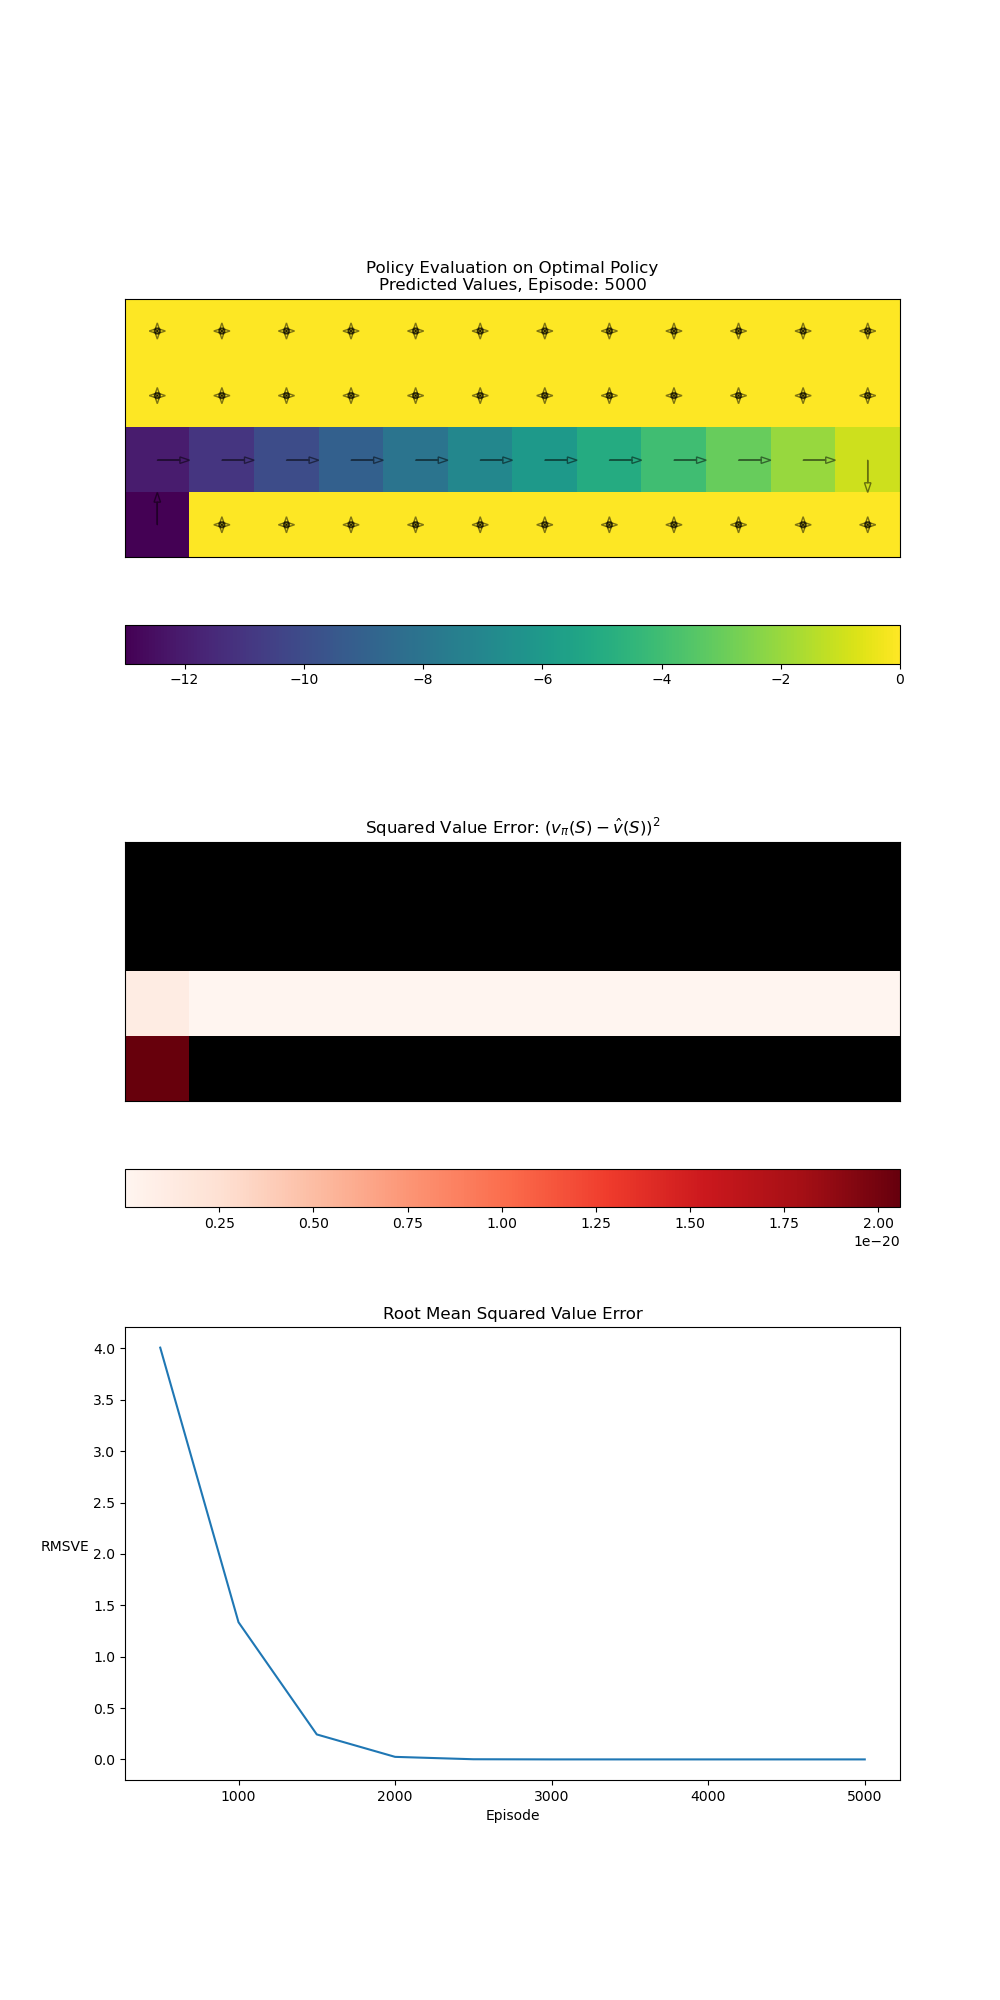

In [105]:
# ---------------
# Discussion Cell
# ---------------

env_info = {"grid_height": 4, "grid_width": 12, "seed": 0}
agent_info = {"discount": 1, "step_size": 0.01, "seed": 0}

# The Optimal Policy that strides just along the cliff
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25
policy[36] = [1, 0, 0, 0]
for i in range(24, 35):
    policy[i] = [0, 0, 0, 1]
policy[35] = [0, 0, 1, 0]

agent_info.update({"policy": policy})

true_values_file = "optimal_policy_value_fn.npy"
_ = run_experiment(env_info, agent_info, num_episodes=5000, experiment_name="Policy Evaluation on Optimal Policy",
                   plot_freq=500, true_values_file=true_values_file)

In [106]:
# -----------
# Graded Cell
# -----------

# The Safe Policy
# Hint: Fill in the array below (as done in the previous cell) based on the safe policy illustration 
# in the environment diagram. This is the policy that strides as far as possible away from the cliff. 
# We call it a "safe" policy because if the environment has any stochasticity, this policy would do a good job in 
# keeping the agent from falling into the cliff (in contrast to the optimal policy shown before). 

# build a uniform random policy
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25

# build an example environment
env = CliffWalkEnvironment()
env.env_init(env_info)

# modify the uniform random policy
for i in range(env_info['grid_height'] - 1, 0, -1):
    policy[i * env_info['grid_width']] = [1, 0, 0, 0]
for j in range(env_info['grid_width']):
    policy[j] = [0, 0, 0, 1]
for i in range(env_info['grid_height'] - 1):
    policy[i * env_info['grid_width'] + (env_info['grid_width'] - 1)] = [0, 0, 1, 0]


In [107]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

width = env_info['grid_width']
height = env_info['grid_height']

# left side of space
for x in range(1, height):
    s = env.state((x, 0))
    
    # go up
    assert np.all(policy[s] == [1, 0, 0, 0])

# top of space
for y in range(width - 1):
    s = env.state((0, y))

    # go right
    assert np.all(policy[s] == [0, 0, 0, 1])
    
# right side of space
for x in range(height - 1):
    s = env.state((x, width - 1))
    
    # go down
    assert np.all(policy[s] == [0, 0, 1, 0])

<IPython.core.display.Javascript object>


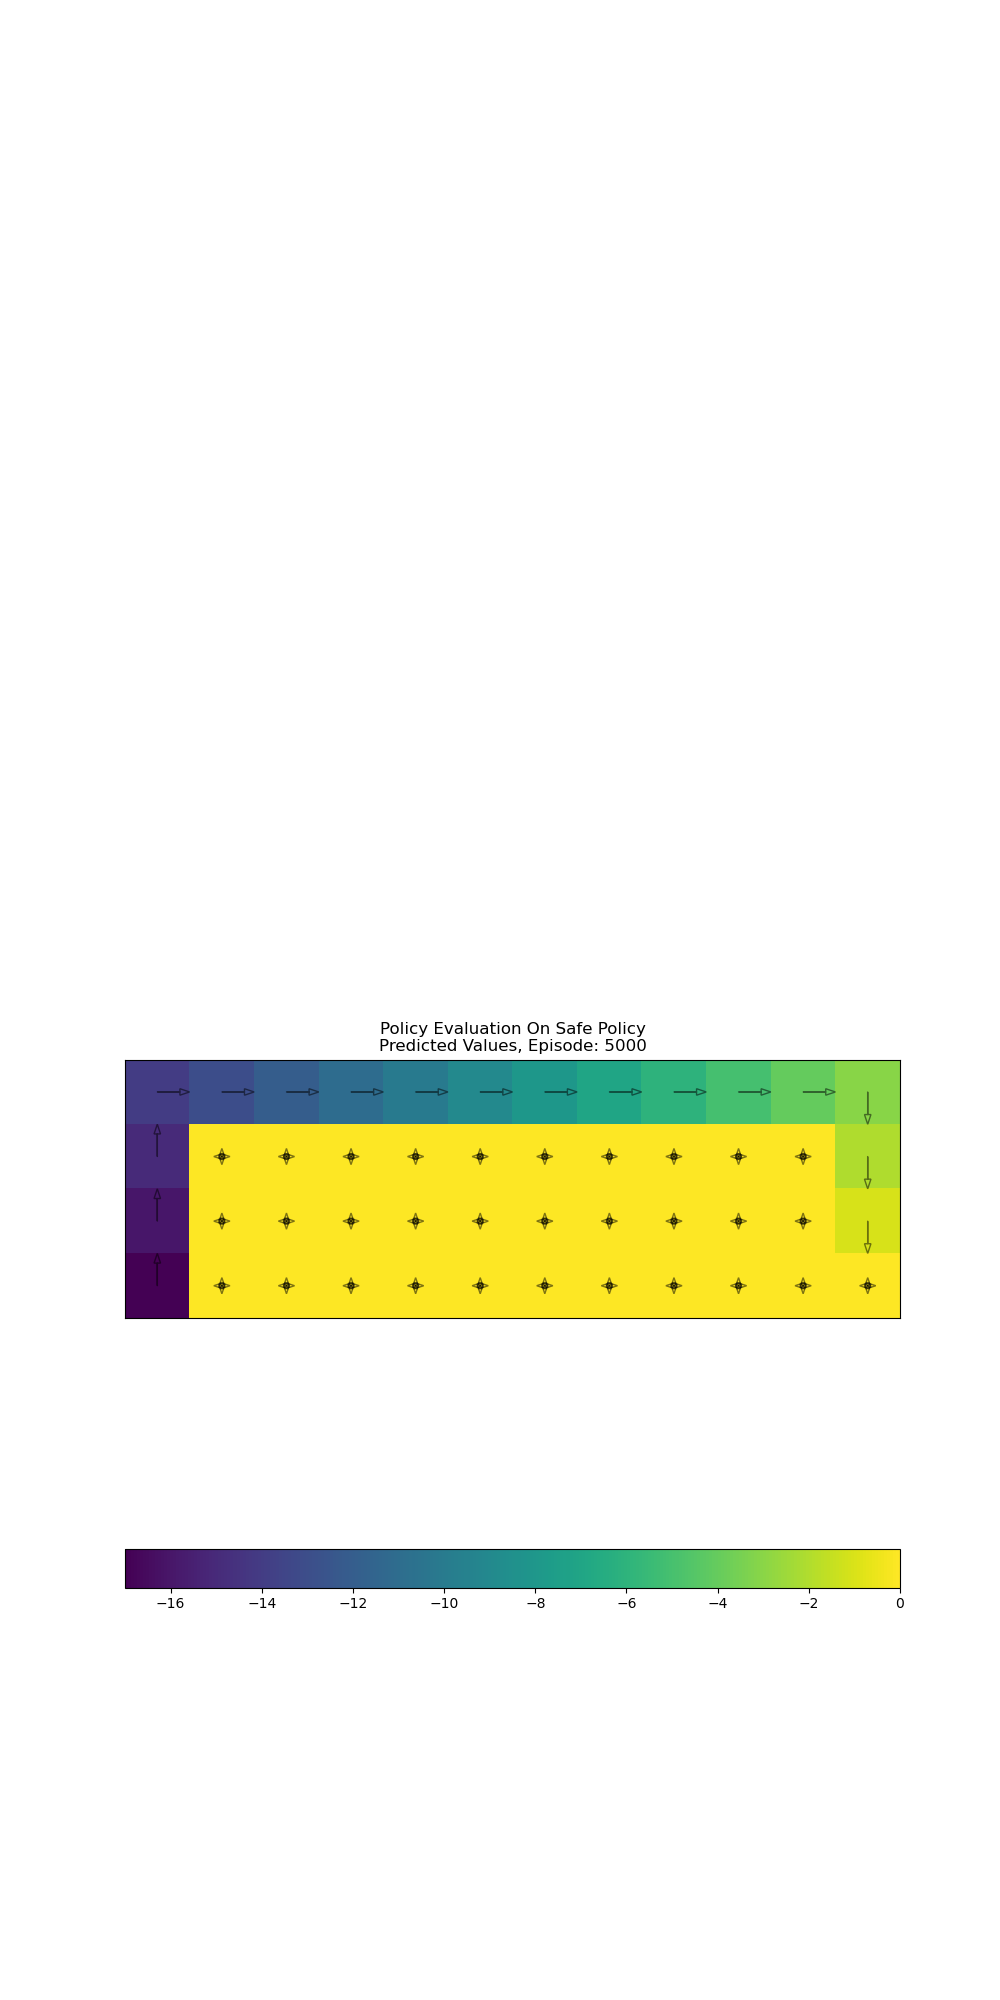

In [108]:
# ---------------
# Discussion Cell
# ---------------

agent_info.update({"policy": policy})
v = run_experiment(env_info, agent_info, experiment_name="Policy Evaluation On Safe Policy", num_episodes=5000, plot_freq=500)

In [ ]:
# ---------------
# Discussion Cell
# ---------------

# A Near Optimal Stochastic Policy
# Now, we try a stochastic policy that deviates a little from the optimal policy seen above. 
# This means we can get different results due to randomness.
# We will thus average the value function estimates we get over multiple runs. 
# This can take some time, upto about 5 minutes from previous testing. 
# NOTE: The autograder will compare . Re-run this cell upon making any changes.

env_info = {"grid_height": 4, "grid_width": 12}
agent_info = {"discount": 1, "step_size": 0.01}

policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25
policy[36] = [0.9, 0.1/3., 0.1/3., 0.1/3.]
for i in range(24, 35):
    policy[i] = [0.1/3., 0.1/3., 0.1/3., 0.9]
policy[35] = [0.1/3., 0.1/3., 0.9, 0.1/3.]
agent_info.update({"policy": policy})
agent_info.update({"step_size": 0.01})

In [ ]:
# ---------------
# Discussion Cell
# ---------------
env_info['seed'] = 0
agent_info['seed'] = 0
v = run_experiment(env_info, agent_info,
               experiment_name="Policy Evaluation On Optimal Policy",
               num_episodes=5000, plot_freq=100)

## Wrapping Up
Congratulations, you have completed assignment 2! In this assignment, we investigated a very useful concept for sample-based online learning: temporal difference. We particularly looked at the prediction problem where the goal is to find the value function corresponding to a given policy. In the next assignment, by learning the action-value function instead of the state-value function, you will get to see how temporal difference learning can be used in control as well.